# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import scipy
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf


import cv2
%matplotlib inline

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize


from samples.carton import carton

# Import COCO config
#sys.path.append(os.path.join(ROOT_DIR, "samples/balloon/"))  # To find local version
CARTON_DIR = os.path.join(ROOT_DIR, "datasets/carton")

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
CARTON_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_carton_0610.h5")

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

# ROS packages
import rospy
import geometry_msgs.msg
import time
import roslib; roslib.load_manifest('ur_driver')
import actionlib
from std_msgs.msg import String
# ROS Image message
from sensor_msgs.msg import Image
from thin_obj_bin_picking.msg import carton_pose
# ROS Image message -> OpenCV2 image converter
from cv_bridge import CvBridge, CvBridgeError
#import tf

Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [2]:
config = carton.CartonConfig()
CARTON_DIR = os.path.join(ROOT_DIR, "datasets/carton")

# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [3]:
# Create model in inference mode
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)



In [4]:
# Load weights trained on MS-COCO
model.load_weights(CARTON_WEIGHTS_PATH, by_name=True)

In [5]:
# Load validation dataset
dataset = carton.CartonDataset()
# dataset.load_carton(CARTON_DIR, "new_images")
dataset.load_carton(CARTON_DIR, "val")
# dataset.load_carton(CARTON_DIR, "real_carton_imgs/1img")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 64
Classes: ['BG', 'green_front', 'green_back']


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [6]:
class_names = dataset.class_names

## Run Object Detection

In [7]:
# Rank the mask areas, output the maximum area
def max_area(area):
    area_max = 0
    index = 0
    for i, a in enumerate(area):
        if(a > area_max):
            area_max = a
            index = i
    return area_max, index

In [8]:
# Select the maximum area mask, output the mask and its corners
def mask_rank(img, mask):
    mask_int = mask.astype(np.uint8)
    area = np.zeros([mask_int.shape[2]], dtype=np.int)
    boxx = np.zeros([4, 2, mask_int.shape[2]], dtype = np.float)
    img_copy = img.copy()
    for i in range(mask_int.shape[2]):        
        mask_copy = mask_int[:,:,i].copy()
        plt.imshow(mask_copy)
        plt.show()
        area[i] = mask_copy.sum()
        print(area[i])
    
    mmax, index = max_area(area)
    im2,contours,hierarchy = cv2.findContours(mask_int[:,:,index].copy(), 1, 2)
    cnt = contours[0]     
    for j in range(len(contours)):
        if(len(contours[j]) > len(cnt)):
            cnt = contours[j]
    hull = cv2.convexHull(cnt,returnPoints = True)
    rect = cv2.minAreaRect(hull)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(img_copy,[box],0,(0,0,255),2)
    plt.imshow(img_copy)
    plt.show()
    print(box)
    return mask_int[:,:,index].copy(), box

In [9]:
# Compute position of mask center and rotation of mask
def get_mask_pose(max_boxx):
    position = (max_boxx[0] + max_boxx[2]) / 2
    # Counterclockwise is positive direction
    if(np.linalg.norm(max_boxx[0]-max_boxx[1]) > np.linalg.norm(max_boxx[1]-max_boxx[2])):
        rotation = math.atan2((max_boxx[2]-max_boxx[1])[1], (max_boxx[2]-max_boxx[1])[0])
        print("rotation 111")
    else:
        rotation = math.atan2((max_boxx[1]-max_boxx[0])[1], (max_boxx[1]-max_boxx[0])[0])
        print("rotation 222")
    pose={
        'x':position[0],
        'y':position[1],
        'rz':rotation
    }
    return pose

In [10]:
is_detect = 0
img_index = 0
def img_index_callback(data):
    global img_index
    global is_detect
    
    print(data.data)
    img_index = data.data
    is_detect = 1


In [11]:
rospy.init_node('img_segmentation')
rospy.Subscriber('/carton_img_index', String, img_index_callback)

functions for carton pose detection

In [12]:
def get_max_area_mask(masks):
    #get the number of masks
    mask_num = masks.shape[2]
    
    largest_mask_idx = 0
    largest_mask_area = 0
    for index in range(mask_num):        
        mask = r['masks'][:,:,index]
        
        #get the area of masks[index]
        temp_mask_pixel_sum = 0
        for row in mask:
            temp_mask_pixel_sum += sum(row)
        
        #compare the result with the 
        if (temp_mask_pixel_sum > largest_mask_area):
            largest_mask_area = temp_mask_pixel_sum
            largest_mask_idx = index
    
    return largest_mask_idx



In [48]:
direct_i = [-1,  0, 1, 0]
direct_j = [ 0, -1, 0, 1]
    

def set_father(i, j, new_father_id, father):
    original_father = father[i][j]
    father[i][j] = new_father_id
    shape=father.shape
    
    for k in range(4):
        if (i+direct_i[k] < shape[0]) and (i+direct_i[k] >= 0) and (j+direct_j[k] < shape[1]) and (j+direct_j[k] >= 0) and (father[i+direct_i[k]][j+direct_j[k]] == original_father):
            set_father(i+direct_i[k], j+direct_j[k], new_father_id, father)

    
def get_largest_region(mask):
    
    shape = mask.shape
    father = np.zeros(shape, dtype=np.uint8)    
    
    father_maximum = 0
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            if (mask[i][j] != 0):

                new_father_flag = 1
                for k in range(4):
                    if (i+direct_i[k] < shape[0]) and (i+direct_i[k] >= 0) and (j+direct_j[k] < shape[1]) and (j+direct_j[k] >= 0) and mask[i+direct_i[k]][j+direct_j[k]] != 0 and father[i+direct_i[k]][j+direct_j[k]] != 0:
                        new_father_flag = 0
                        if father[i][j] == 0:
                            father[i][j] = father[i+direct_i[k]][j+direct_j[k]]
                        elif father[i][j] != father[i+direct_i[k]][j+direct_j[k]]:
                            set_father(i, j, father[i+direct_i[k]][j+direct_j[k]], father)
                if new_father_flag == 1:
                    father_maximum += 1
                    father[i][j] = father_maximum
    area = np.zeros(father_maximum+1)
    for i in range(shape[0]):
        for j in range(shape[1]):
            if (mask[i][j] != 0):
                area[father[i][j]] += 1

    indexs = np.where(area == np.amax(area))
    max_area_idx = indexs[0][0]
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            if (father[i][j] != max_area_idx):
                mask[i][j] = 0
    return mask

# mask = np.zeros((5, 5), dtype=np.uint8)

# mask[0][0] = 255
# mask[1][1] = 255
# mask[1][2] = 255
# mask[2][1] = 255
# mask[2][2] = 255
# mask[3][2] = 255

# mask[1][4] = 255
# mask[2][4] = 255

# mask[3][3] = 255
# mask[3][4] = 255

# mask[4][0] = 255
# mask[0][1] = 255

# print(mask)
# mask = get_largest_region(mask)
# print(mask)

In [66]:
import scipy
import cv2
import numpy as np
from matplotlib import pyplot as plt
import scipy.io as sio

def get_carton_pose(image, r):
#     img_index = 1
#     image =  scipy.misc.imread('/home/qxuaj/catkin_ws/src/thin_obj_bin_picking/image/'+ str(img_index) +'.jpeg')
    
    index = get_max_area_mask(r['masks'])              
    print("The largest area img is :", index)
    
    mask = r['masks'];
    mask1 = mask[:, :, index] * 255;
    mask1 = np.uint8(mask1)
    #print((mask1.max()))    
    
    #make the mask larger for robustness
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(20, 20))
    mask1 = cv2.dilate(mask1, kernel)
    
    
    #Erode and then dilate the image to eliminate the noise
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(30, 30))
    mask_eroded = cv2.erode(mask1, kernel)
    mask_dilated = cv2.dilate(mask_eroded, kernel)

    mask_dilated = cv2.dilate(mask_dilated, kernel)
    mask_dilated = cv2.erode(mask_dilated, kernel)
    
    #get the center of the carton
    ret,thresh = cv2.threshold(mask_dilated,127,255,0)
    im2,contours,hierarchy = cv2.findContours(thresh, 1, 2)
    cnt = contours[0]

    M_carton = cv2.moments(cnt)
    cx_carton = int(M_carton['m10']/M_carton['m00'])
    cy_carton = int(M_carton['m01']/M_carton['m00'])
    
    #filter the gree bar

#     lower_green = np.array([0,80,0])
#     upper_green = np.array([45,255,255])
    
    lower_green = np.array([0,80,0])
    upper_green = np.array([75,255,255])
    
    green_mask = cv2.inRange(image, lower_green, upper_green)
    res = cv2.bitwise_and(image,image, mask= green_mask)
    
    plt.figure(figsize=(8,8),dpi=80)
    plt.imshow(res)
    plt.title('green filter')
    
    mask_green_carton = cv2.bitwise_and(mask_dilated, green_mask)
    
    
    mask_green_carton_processed = mask_green_carton

    #Erode and then dilate the image to eliminate the noise
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2, 2))
    mask_eroded = cv2.erode(mask_green_carton, kernel)
    mask_green_carton_processed = cv2.dilate(mask_eroded, kernel)
    
    #dilate and then erode the image to fill the words
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(9, 9))
    mask_dilated = cv2.dilate(mask_green_carton_processed, kernel)
    mask_green_carton_processed = cv2.erode(mask_dilated, kernel)
    
    print('green_max', np.amax(mask_green_carton_processed))
    print('shape', mask_green_carton_processed.shape)
    print('dtype', mask_green_carton_processed.dtype.name)
    
    
    mask_green_carton = get_largest_region(mask_green_carton_processed)
    
    
    
    
    plt.figure(figsize=(8,8),dpi=80)
    plt.imshow(mask_green_carton_processed)
    plt.title('mask_green_carton_processed')
    
    _, contours,hierarchy = cv2.findContours(mask_green_carton_processed,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    cnt = contours[0]

    #calculate center point
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    
    #draw bounding point
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    img_result = cv2.drawContours(image.copy(),[box],0,(0,0,255),8)

    #draw center point
    cv2.circle(img_result, (cx_carton, cy_carton), 8, (255, 0, 255), 8)
    
    center_points = [[0, 0], [0, 0], [0, 0], [0, 0]]
    center_dist = [[0, 0], [0, 1], [0, 2], [0, 3]]
    for i in range(4):
        center_points[i][0] = (box[i][0] + box[(i+1)%4][0]) / 2 
        center_points[i][1] = (box[i][1] + box[(i+1)%4][1]) / 2 
        center_dist[i][0] = math.sqrt((center_points[i][0] - cx)**2 + (center_points[i][1] - cy)**2)

    #get farest two centers
    for i in range(4):
        for j in range(i+1, 4):
            if (center_dist[i][0] < center_dist[j][0]):
                tmp = center_dist[i][0]
                center_dist[i][0] = center_dist[j][0]
                center_dist[j][0] = tmp

                tmp = center_dist[i][1]
                center_dist[i][1] = center_dist[j][1]
                center_dist[j][1] = tmp

    far_point1_x = int(center_points[center_dist[0][1]][0])
    far_point1_y = int(center_points[center_dist[0][1]][1])

    far_point2_x = int(center_points[center_dist[1][1]][0])
    far_point2_y = int(center_points[center_dist[1][1]][1])
    
    dist1 = math.sqrt((far_point1_x - cx_carton)**2 + (far_point1_y - cy_carton)**2)
    dist2 = math.sqrt((far_point2_x - cx_carton)**2 + (far_point2_y - cy_carton)**2)

    #update cx and cy real value
    cx = int((far_point1_x + far_point2_x) / 2)
    cy = int((far_point1_y + far_point2_y) / 2)
    cv2.circle(img_result, (cx, cy), 8, (255, 0, 0), 8)

    if dist1 < dist2:
        tilt_point_x = int(far_point1_x + (far_point1_x - cx) * (104.0 / 81.5)) #104/81.3
        tilt_point_y = int(far_point1_y + (far_point1_y - cy) * (104.0 / 81.5)) #104/81.3

        fixed_point_x = far_point2_x
        fixed_point_y = far_point2_y
    else:
        tilt_point_x = int(far_point2_x + (far_point2_x - cx) * (104.0 / 81.5))
        tilt_point_y = int(far_point2_y + (far_point2_y - cy) * (104.0 / 81.5))

        fixed_point_x = far_point1_x
        fixed_point_y = far_point1_y

    cv2.circle(img_result, (tilt_point_x, tilt_point_y), 8, (255, 255, 0), 8)
    cv2.circle(img_result, (fixed_point_x, fixed_point_y), 8, (0, 255, 0), 8)
    
    plt.figure(figsize=(8,8),dpi=80)
    plt.imshow(img_result)
    plt.title('img_result')

    #calculate angle
    dy = - (fixed_point_y - tilt_point_y)
    dx = fixed_point_x - tilt_point_x
    
    print('dy = '+str(dy)+' dx='+str(dx) )
    
    plt.show()
    pose={
        'Hong_x':tilt_point_x,
        'Hong_y':tilt_point_y,
        'Kong_x':fixed_point_x,
        'Kong_y':fixed_point_y,
        'rz':math.atan2(dy, dx)
    }
    return pose


    

0
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  119.30000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


/home/qxuaj/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


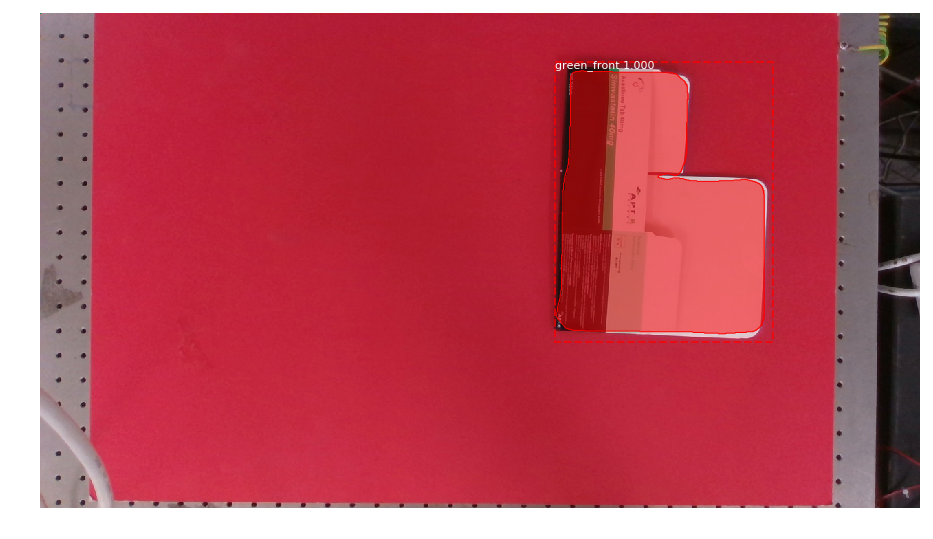

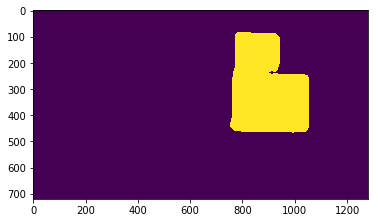

91158


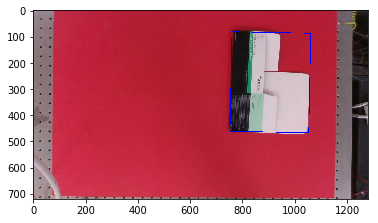

[[1053  467]
 [ 752  461]
 [ 760   82]
 [1061   88]]


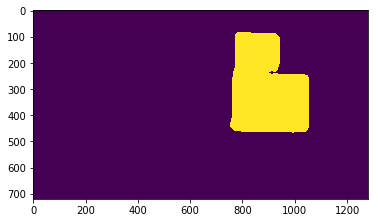

The largest area img is : 0
green_max 255
shape (720, 1280)
dtype uint8
dy = 401 dx=18


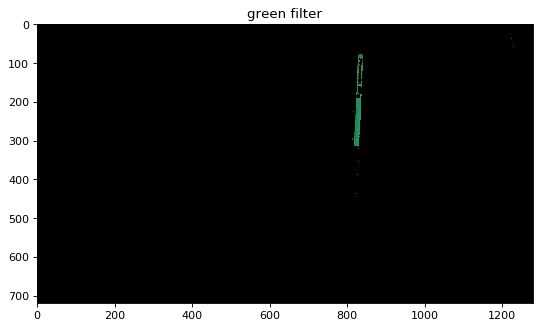

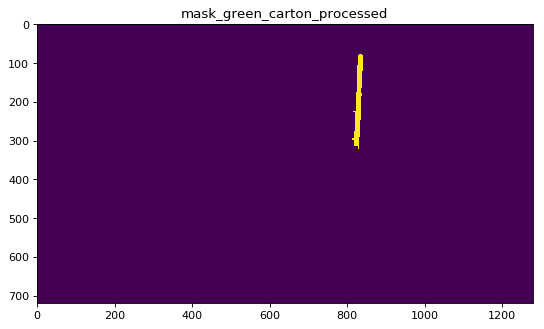

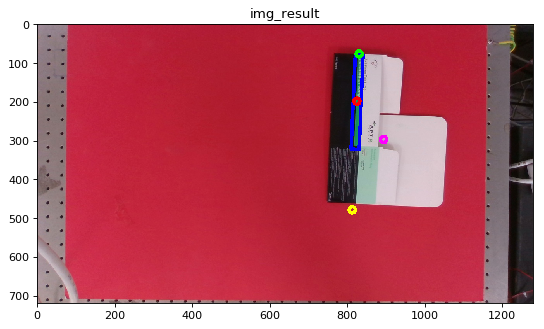

Hong: 813 480
Kong: 831 79
87.42984490915356

Hong: 0.128421   -0.0851634
Kong: 0.11693069999999998   0.053396099999999995
1
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  122.30000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


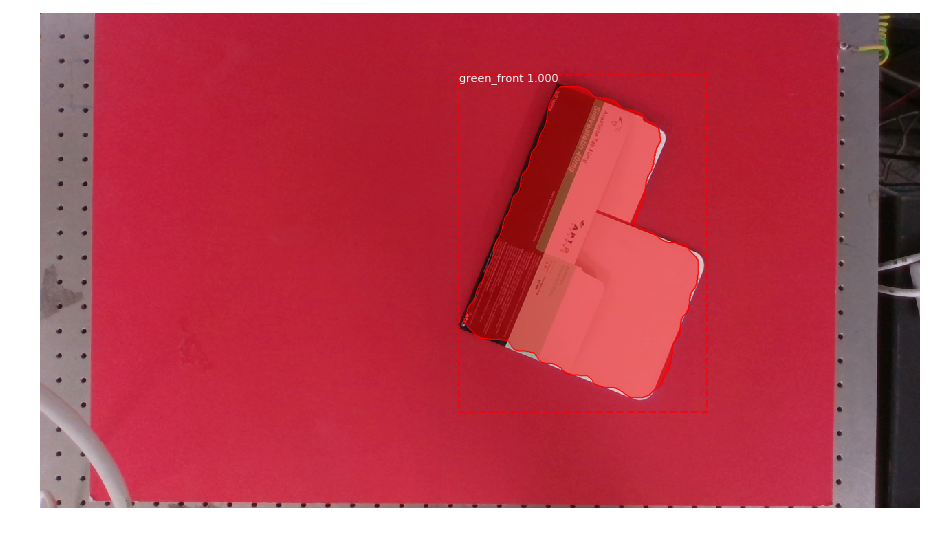

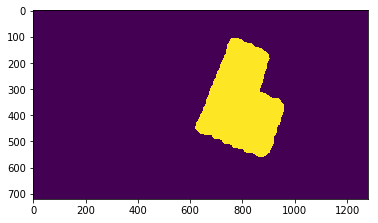

93566


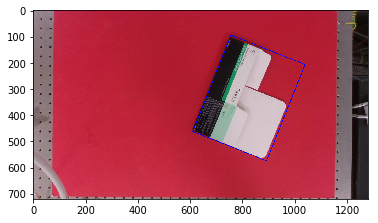

[[ 892  574]
 [ 610  462]
 [ 756   95]
 [1039  207]]


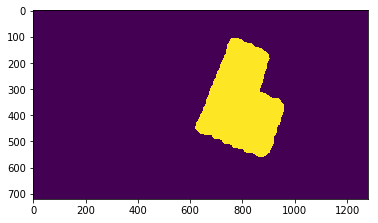

The largest area img is : 0
green_max 255
shape (720, 1280)
dtype uint8
dy = 357 dx=145


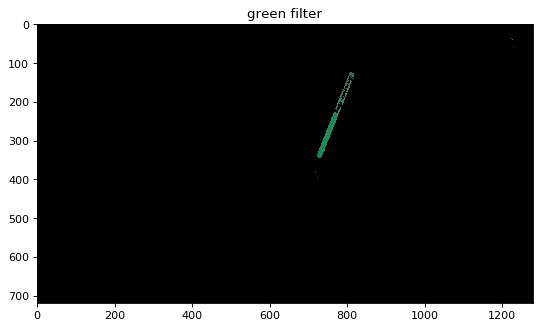

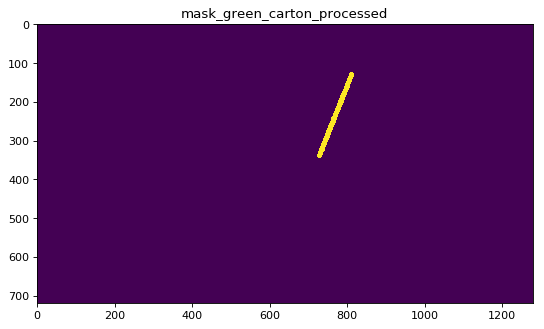

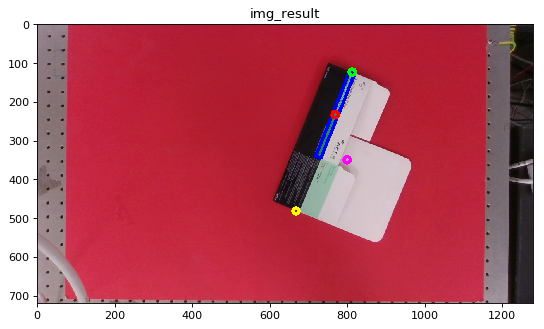

Hong: 668 483
Kong: 813 126
67.894856696402

Hong: 0.030415499999999998   -0.0831357
Kong: 0.1047645   0.0851634
0
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  124.30000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


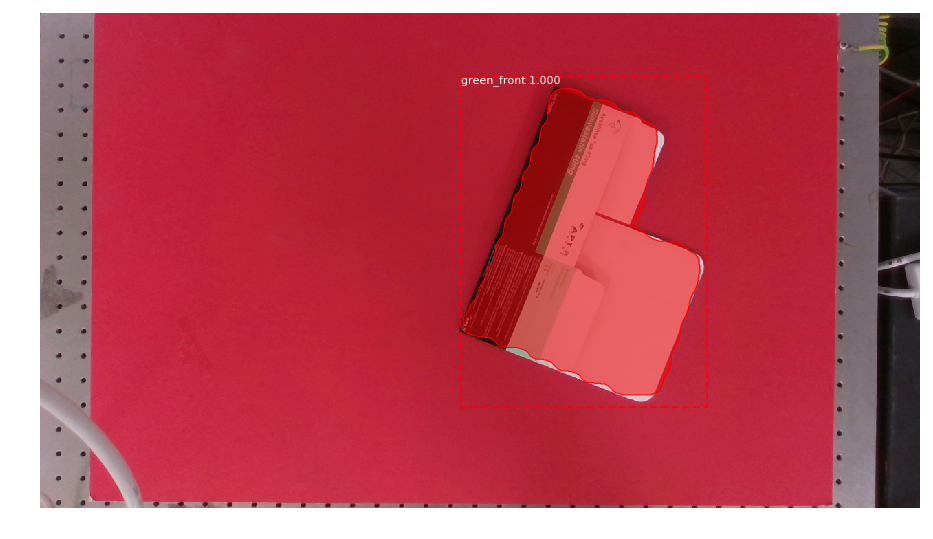

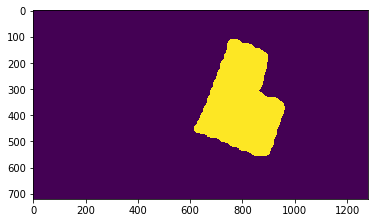

93091


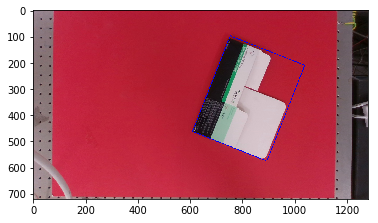

[[ 893  575]
 [ 609  462]
 [ 753   98]
 [1038  210]]


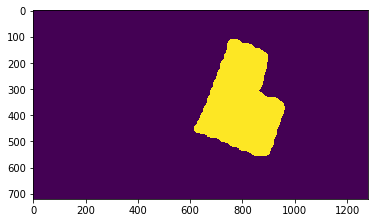

The largest area img is : 0
green_max 255
shape (720, 1280)
dtype uint8
dy = 366 dx=141


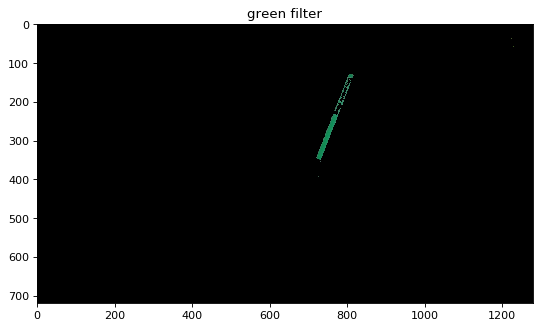

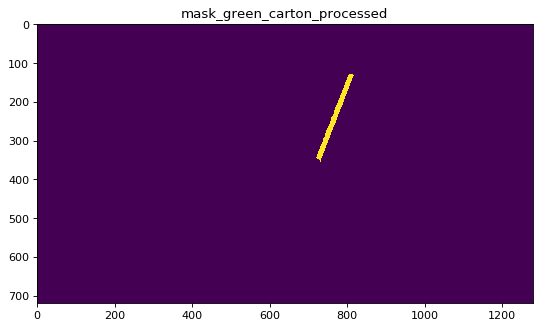

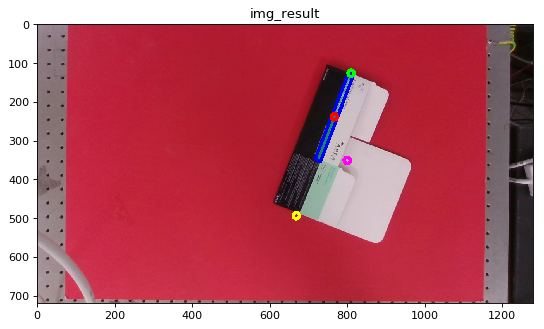

Hong: 669 495
Kong: 810 129
68.93102506806878

Hong: 0.031091399999999998   -0.07502489999999999
Kong: 0.10273679999999999   0.0871911
0
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  240.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  109.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


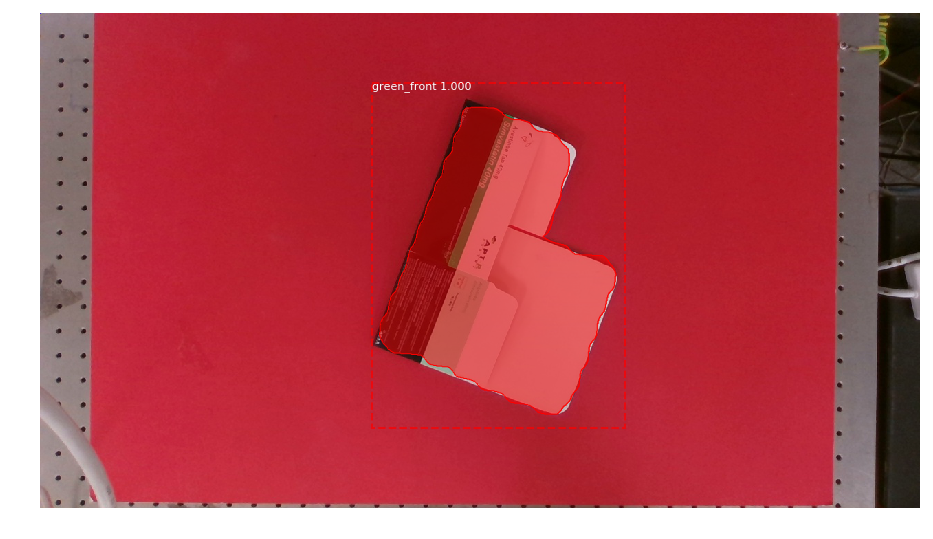

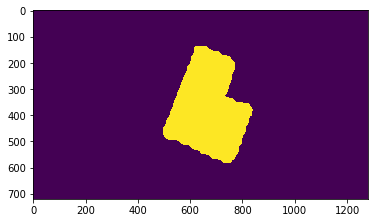

93103


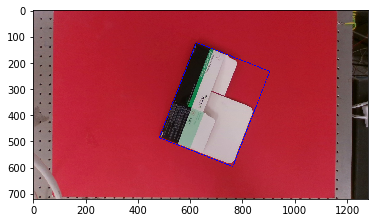

[[763 596]
 [482 486]
 [624 123]
 [904 233]]


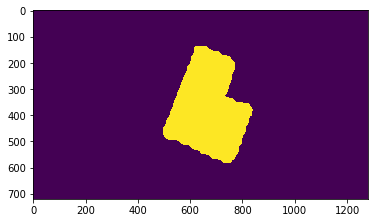

The largest area img is : 0
green_max 255
shape (720, 1280)
dtype uint8
dy = 362 dx=136


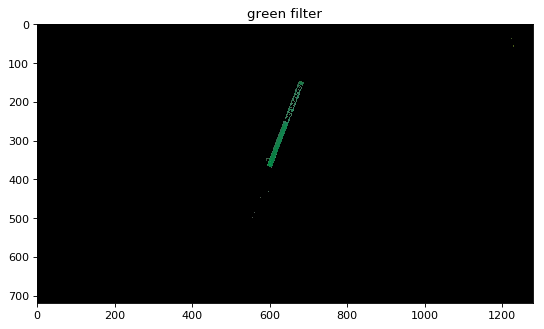

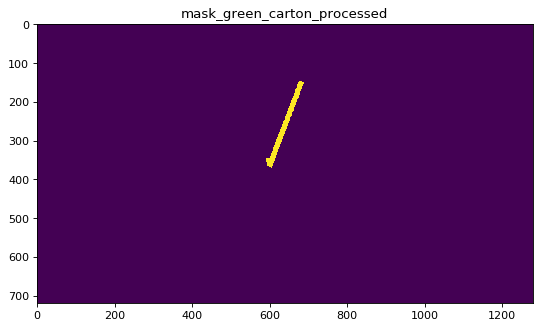

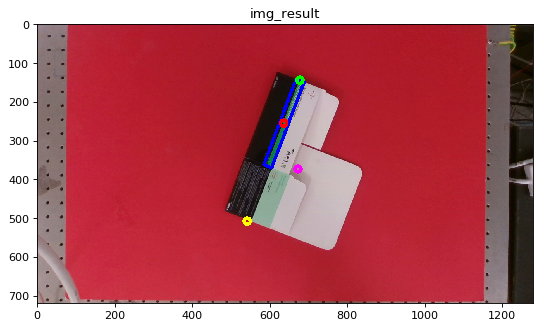

Hong: 542 509
Kong: 678 147
69.40927210940264

Hong: -0.054747899999999995   -0.06556229999999999
Kong: 0.013517999999999999   0.0993573
1
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  122.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


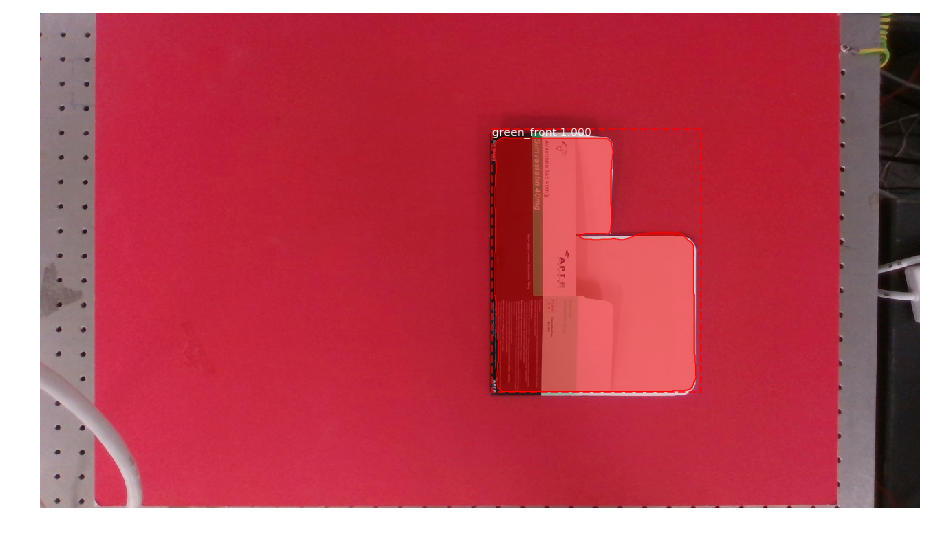

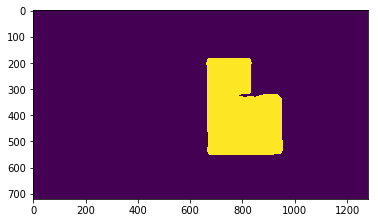

88834


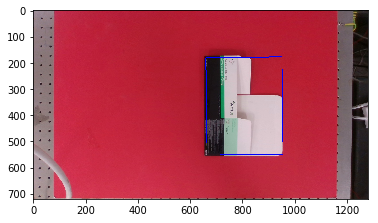

[[664 552]
 [660 181]
 [951 178]
 [955 549]]


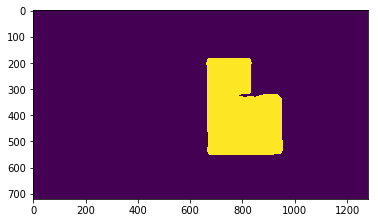

The largest area img is : 0
green_max 255
shape (720, 1280)
dtype uint8
dy = 385 dx=-2


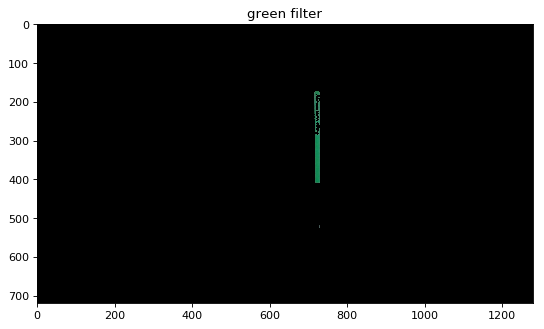

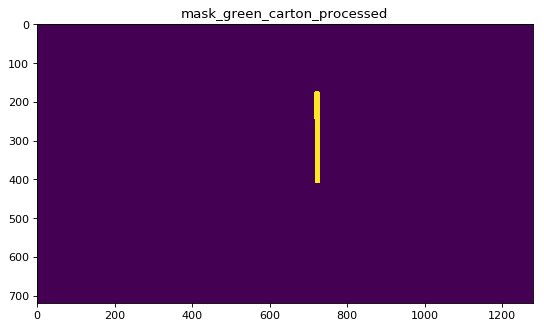

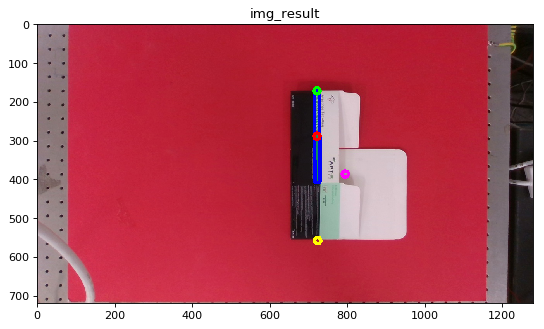

Hong: 724 559
Kong: 722 174
90.29763773572348

Hong: 0.06826589999999999   -0.0317673
Kong: 0.0432576   0.11760659999999999
2
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


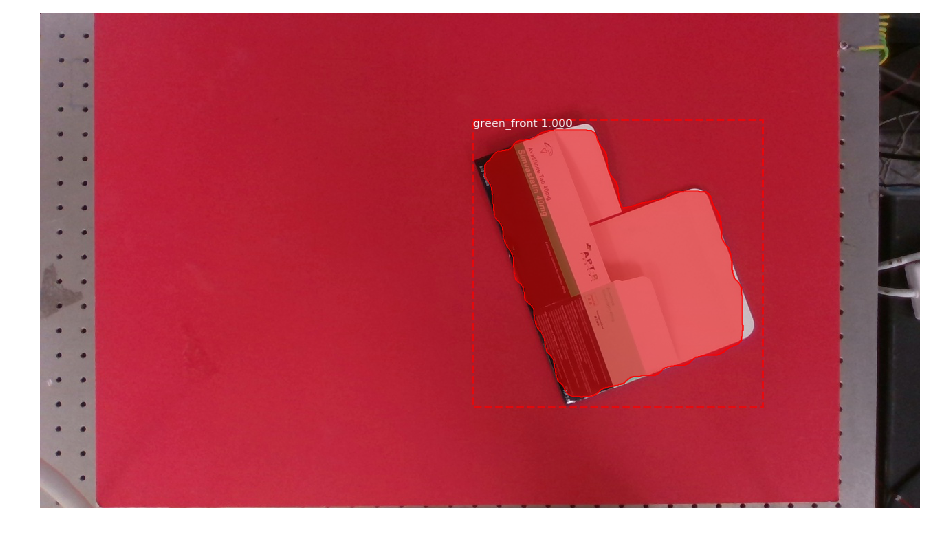

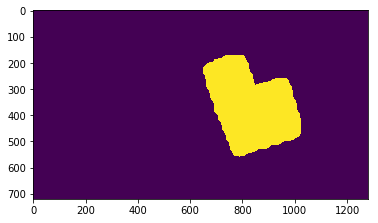

93957


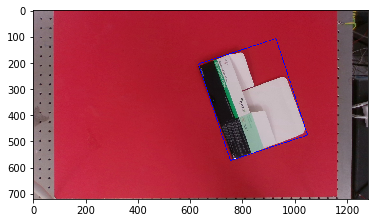

[[ 754  573]
 [ 632  205]
 [ 928  108]
 [1049  476]]


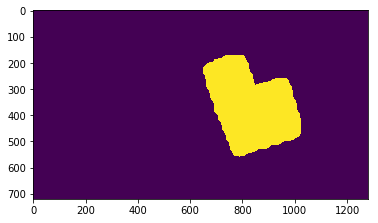

The largest area img is : 0
green_max 255
shape (720, 1280)
dtype uint8
dy = 363 dx=-137


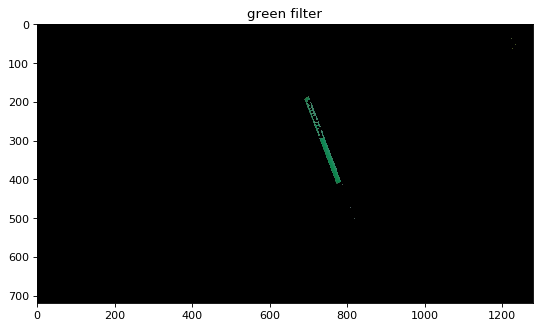

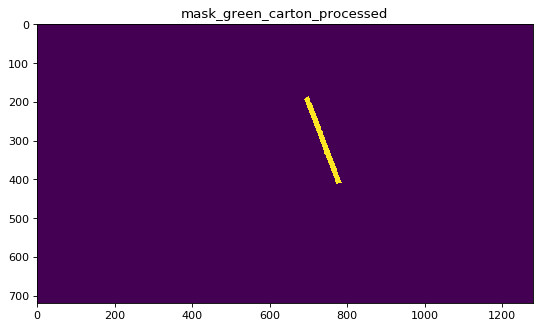

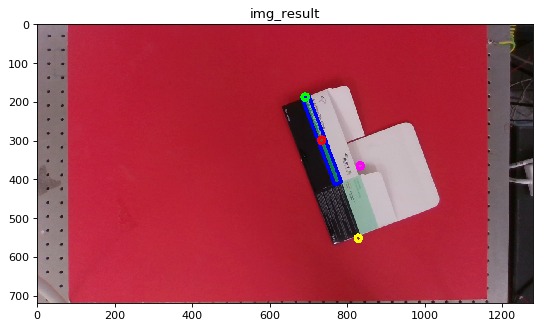

Hong: 829 553
Kong: 692 190
110.67703160283547

Hong: 0.1392354   -0.0358227
Kong: 0.0229806   0.128421


In [ ]:
# from camera calibration
# cx = 320.37#312.8339
# cy = 236.51#247.5236

cx = 658#643#1280
cy = 0#671#720

hong_cx = 623
hong_cy = 606


while(True):
    
    if(is_detect == 1):
        pose_pub = rospy.Publisher('/carton_pose', carton_pose, queue_size=10)
        # Load a the image
        #image = scipy.misc.imread('IMG_0393.JPG')
        image = scipy.misc.imread('/home/qxuaj/Desktop/carton_erecting/image/'+ img_index +'.jpeg')

        # Run detection
        results = model.detect([image], verbose=1)
        
        # Visualize results
        r = results[0]
        visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])
        
        #img = cv2.imread('IMG_0393.JPG',0)
        #img = cv2.imread('/home/qxuaj/Desktop/carton_erecting/imagee/'+ img_index +'.jpeg',0)
        #print(mask_rank(img, r['masks']))
        mask_max, box_max = mask_rank(image, r['masks'])

        plt.imshow(mask_max)
        plt.show()
        
#         pose = get_mask_pose(img, r)
        pose = get_carton_pose(image, r)
        
        print('Hong:', pose['Hong_x'], pose['Hong_y'])
        print('Kong:', pose['Kong_x'], pose['Kong_y'])
        print(pose['rz']*180/math.pi)
        
        carton_pose_msg = carton_pose()
        #carton_pose_msg.x = (pose['x'] - cx) / fx # transfer pixel position to camera frame coordinates
        #carton_pose_msg.y = (pose['y'] - cy) / fy
        carton_pose_msg.Hong_x = (pose['Hong_x'] - hong_cx) * 0.6759 * 0.001 # transfer pixel position to camera frame coordinates
        carton_pose_msg.Hong_y = (pose['Hong_y'] - hong_cy) * 0.6759 * 0.001 #183 165 332
        
        carton_pose_msg.Kong_x = (pose['Kong_x'] - cx) * 0.6759 * 0.001 # transfer pixel position to camera frame coordinates
        carton_pose_msg.Kong_y = (pose['Kong_y'] - cy) * 0.6759 * 0.001 #183 165 332
        
        
        carton_pose_msg.angle = pose['rz']
        pose_pub.publish(carton_pose_msg)
        print()
        print('Hong:', carton_pose_msg.Hong_x, " ", carton_pose_msg.Hong_y)
        print('Kong:', carton_pose_msg.Kong_x, " ", carton_pose_msg.Kong_y)
        
        is_detect = 0

In [67]:
sys.setrecursionlimit(500000)

In [68]:
is_detect = 1

# not move point
# x:643 
# y:671

#move 12.5cm
#x:858 
#y:661

In [ ]:
858-643

In [ ]:
654-643

In [ ]:
417 505

In [ ]:
143 
751